In [2]:
setwd("/projects/CARDIPS/analysis/epigenome_resource")
source("analyses/jennifer/notebooks/functions.R")

set.seed(5366)

# Figure 7: Plot QTL and GWAS associations for fetal-unique association with BMI

## read supplemental table containing GWAS colocalizations

In [3]:
gwas_coloc = fread("manuscript/tables/Table_SX_GWAS_Colocalizations.txt", data.table = F) %>% filter(Colocalized == T)
head(gwas_coloc,3)

,Tissue,Trait_Description,Trait_ID,Cluster_ID,QTL_Combination,Membership,Element_ID,Condition,Element_Cond,Element_Name,⋯,Beta.GWAS,SE.GWAS,Pvalue.GWAS,99Credible_Set_Size,Colocalized,Has_TFBS,GWAS_Index,GWAS_QTL_Combination_Collapse,Fetal_Unique_QTL,Fetal_Unique_GWAS_Locus
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<int>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<chr>
1,CVPC,Aging,timmers2020_healthspan_lifespan_longevity,CVPC_10833,eQTL,Singleton,ENSG00000182511.12,1,ENSG00000182511.12_1,FES,⋯,-0.009921,0.001680,3.52501e-09,5,TRUE,FALSE,15_90885406,caQTL-haQTL-eQTL,TRUE,FALSE
2,CVPC,Aging,timmers2020_healthspan_lifespan_longevity,CVPC_10854,haQTL,Singleton,cvpc_chip_peak_21796,0,cvpc_chip_peak_21796_0,cvpc_chip_peak_21796,⋯,-0.009921,0.001680,3.52501e-09,8,TRUE,FALSE,15_90885406,caQTL-haQTL-eQTL,FALSE,FALSE
3,CVPC,Aging,timmers2020_healthspan_lifespan_longevity,CVPC_11914,caQTL,Singleton,cvpc_atac_peak_101289,0,cvpc_atac_peak_101289_0,cvpc_atac_peak_101289,⋯,0.012461,0.001815,6.58645e-12,3,TRUE,FALSE,16_89959744,caQTL,FALSE,FALSE


## read supplemental table for GWAS manifest

In [4]:
manifest = fread("manuscript/tables/Table_SX_GWAS_Manifest.txt", data.table = F)
head(manifest,5)

,Trait_Description,Trait_ID,Download_Source,Publication
,<chr>,<chr>,<chr>,<chr>
1,Aging,timmers2020_healthspan_lifespan_longevity,https://doi.org/10.7488/ds/2793,"Timmers et al., Nature Communications, 2020 (PMID: 32678081)"
2,Angina Pectoris,icd10-I20-both_sexes.meta,https://pan.ukbb.broadinstitute.org/,Pan-UK Biobank
3,Atrial Fibrillation,icd10-I48-both_sexes.meta,https://pan.ukbb.broadinstitute.org/,Pan-UK Biobank
4,Birth Weight,BW3_EUR_summary_stats,http://egg-consortium.org/birth-weight-2016.html,"Horikoshi et al., Nature, 2016 (PMID: 27680694)"
5,Body Mass Index,continuous-23104-both_sexes-irnt.meta,https://pan.ukbb.broadinstitute.org/,Pan-UK Biobank


## read gene information

In [5]:
geneinfo = fread("/reference/private/Gencode.v44lift38/gene_info.txt")
head(geneinfo,3)

chrom,start,end,strand,gene_id,gene_name,gene_type,havana_gene
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
chr1,11869,14409,+,ENSG00000290825.1,DDX11L2,lncRNA,
chr1,12010,13670,+,ENSG00000223972.6,DDX11L1,transcribed_unprocessed_pseudogene,OTTHUMG00000000961.2
chr1,14404,29570,-,ENSG00000227232.5,WASH7P,unprocessed_pseudogene,OTTHUMG00000000958.1


## read supplemental table for QTL module information

In [7]:
mods = fread("/frazer01/home/tarthur/projects/Resource/SupplementalTables/TableS11_QTLModules.txt", data.table = F) 
colnames(mods) = gsub(" ", "_", colnames(mods))
mods = mods %>%mutate(Element_Cond = paste(Element_ID, Condition, sep = "_"))
head(mods,3)

,Tissue,Cluster_ID,Element_ID,Condition,Molecular_QTL_Type,Membership,No._Colocalizations,No._QTLs_in_Module,Element_Cond
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<chr>
1,iPSC,iPSC_1,ipsc_atac_peak_17280,0,caQTL,Module,8,10,ipsc_atac_peak_17280_0
2,iPSC,iPSC_1,ipsc_atac_peak_17286,0,caQTL,Module,9,10,ipsc_atac_peak_17286_0
3,iPSC,iPSC_1,ipsc_atac_peak_17287,0,caQTL,Module,9,10,ipsc_atac_peak_17287_0


In [6]:
# # gwas_coloc = fread("analyses/jennifer/gwas_coloc/all.gwas_summary.relevant_traits.txt", data.table = F) %>% filter(coloc_gwas == T)
# mods = fread("analyses/jennifer/summary_files/all.qtl_modules.H4_0.8.txt", data.table = F)
# manifest = fread("analyses/jennifer/gwas_independent/subset_manifest.txt", data.table = F)
# geneinfo = fread("/reference/private/Gencode.v44lift38/gene_info.txt")

## set variables for plotting

In [9]:
chr = 4
tissue = "PPC"
qtl4gwas = "ppc_atac_peak_197599_0" # any element_cond in the cluster

## extract info for plotting

In [10]:
# get cluster ID
cluster = unique(mods[mods$Element_Cond == qtl4gwas,]$Cluster_ID)
message(paste("Cluster ID:", cluster), appendLF = F)

# get element IDs in cluster
elements = mods[mods$Cluster_ID == cluster,]$Element_Cond
message(paste("Elements in cluster:", paste(elements, collapse = ", ")), appendLF = F)

# get all traits associated with the cluster
traits = gwas_coloc[gwas_coloc$Cluster_ID == cluster,]$Trait_ID

# get lead candidate causal SNP
topsnp = gwas_coloc %>% 
    filter(Cluster_ID == cluster) %>% 
    dplyr::select(Element_ID, Trait_Description ,Top_SNP_ID, Top_SNP_PP) %>% 
    dplyr::arrange(desc(Top_SNP_PP)) %>% 
    head(1) %>% pull(Top_SNP_ID)

message(paste("Top SNP ID:", topsnp), appendLF = F)

# extract SNP position
topsnp_pos = as.numeric(unlist(strsplit(topsnp, "_"))[3])
message(paste("Top SNP position:", topsnp_pos), appendLF = F)

Cluster ID: PPC_14193
Elements in cluster: ppc_atac_peak_197599_0
Top SNP ID: VAR_4_54631000_C_T
Top SNP position: 54631000


## get QTL p-value associations

In [12]:
qtldata = as.data.frame(rbindlist(lapply(elements, function(id)
{
    element_id = substr(id, 1, nchar(id) -  2)
    qtl_type = substr(id, nchar(id), nchar(id))
    analysis = ifelse(id %like% "ENSG", "eqtls", ifelse(id %like% "atac", "caqtls", "haqtls"))
    qtl_file = paste(analysis, tissue, "step_4/qtl_by_element/qtl", paste("qtl", element_id, "txt", sep = "."), sep = "/")
    message(paste("Reading file:", qtl_file), appendLF = F)
    if (file.exists(qtl_file))
    {
        fread(qtl_file, data.table = F) %>% filter(type == qtl_type) 
    }
}))) %>% dplyr::select(chrom, pos, pval, element_id) %>% mutate(thresh = 5e-05)  %>% mutate(chrom = gsub("chr", "", chrom))

head(qtldata,3)

Reading file: caqtls/PPC/step_4/qtl_by_element/qtl/qtl.ppc_atac_peak_197599.txt


,chrom,pos,pval,element_id,thresh
,<chr>,<int>,<dbl>,<chr>,<dbl>
1,4,54544847,0.4904214,ppc_atac_peak_197599,5e-05
2,4,54544920,0.2345660,ppc_atac_peak_197599,5e-05
3,4,54544972,0.1014669,ppc_atac_peak_197599,5e-05


## read GWAS colocalization results

In [15]:
qtl_type = substr(qtl4gwas, nchar(qtl4gwas), nchar(qtl4gwas))
element_id = substr(qtl4gwas, 1, nchar(qtl4gwas) - 2)
analysis = ifelse(qtl4gwas %like% "ENSG", "eqtls", ifelse(qtl4gwas %like% "atac", "caqtls", "haqtls"))
gwas_file = paste("analyses/jennifer/gwas_coloc", analysis, tissue, paste(paste(qtl_type, element_id, sep = "-"), "robj", sep = "."), sep = "/")
message(paste("Reading:", gwas_file), appendLF = F)

load(gwas_file, verbose = T) # outputs a list of dataframes for each trait

Reading: analyses/jennifer/gwas_coloc/caqtls/PPC/0-ppc_atac_peak_197599.robj


Loading objects:
  outlist


In [18]:
head(outlist[[1]]$input,2) # data input for GWAS colocalization (x = QTL, y = GWAS)

,id,a1.x,a2.x,beta.x,se.x,maf.x,p.x,bonferroni,tests,a1.y,a2.y,beta.y,se.y,p.y,n,maf.y
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,VAR_4_54544847_A_G,A,G,0.3534883,0.5131295,0.0750916,0.4904214,1,251,A,G,-0.004295,0.004463,0.33581493,400963,0.08098
2,VAR_4_54544920_A_G,A,G,-0.3568426,0.3011744,0.2527470,0.2345660,1,251,A,G,-0.006329,0.003028,0.03655948,400963,0.20230


## get GWAS p-value associations for each trait that colocalized with the cluster

In [16]:
message(paste("Getting data for the following traits:", paste(unique(traits), collapse = "\n")), appendLF = F)

gwasdata = as.data.frame(rbindlist(lapply(unique(traits), function(trait)
{
    out = outlist[[trait]]$input %>% 
        mutate(pos = unlist(lapply(id, function(x) { as.numeric(unlist(strsplit(x, "_"))[3]) }))) %>% 
        mutate(chrom = unlist(lapply(id, function(x) { as.numeric(unlist(strsplit(x, "_"))[2] )}))) %>%
        select(chrom, pos, p.y) %>% 
        mutate(element_id = manifest[manifest$Trait_ID == trait,]$Trait_Description) %>% dplyr::rename(pval = p.y)
    if (nrow(out) > 0)
    {
        return(out)
    }
}))) %>% mutate(thresh = 5e-08)

Getting data for the following traits: continuous-23104-both_sexes-irnt.meta


## concatenate QTL and GWAS associations

In [19]:
# concatenate QTL and GWAS associations
qtldata = rbind(qtldata, gwasdata)


## annotate which association is for eQTL, caQTL, haQTL, or GWAS

In [20]:
qtldata$type = ifelse(qtldata$element_id %like% "ENSG", "eqtl",
                       ifelse(qtldata$element_id %like% "atac", "caqtl",
                              ifelse(qtldata$element_id %like% "chip", "haqtl", "gwas")))

In [21]:
unique(qtldata$element_id)

[1] "ppc_atac_peak_197599" "Body Mass Index"

## rename and order

In [22]:
change_names = list() # names you want to change in plot
order = c("Body Mass Index", "ppc_atac_peak_197599") # order you want them to be plotted (with updated names)

In [23]:
# 9. Update names and IDs. Order
for (name in names(change_names))
{
    qtldata[qtldata$element_id == name,]$element_id = change_names[[name]]
}

print(unique(qtldata$element_id))
qtldata$element_id = factor(qtldata$element_id, levels = order)


[1] "ppc_atac_peak_197599" "Body Mass Index"     


## run plink to calculate LD with lead SNP

In [24]:
# first write all snps to test for LD
qtldata$id = paste(qtldata$chrom, qtldata$pos, sep = "_")
writeLines(unique(qtldata$id), "analyses/jennifer/scratch/snps.txt", sep = "\n")

# run LD plink
reference = paste("analyses/jennifer/gwas_independent/reference", paste0("chr", chr), sep = "/")
out = "analyses/jennifer/scratch/plink"
cmd = paste("plink --extract", "analyses/jennifer/scratch/snps.txt", "--bfile", reference, "--r2", "square", "--out", out, "--make-bed")

message(cmd)
system(cmd)

# read bim file, which contains the list of snps (needed to add rownames and colnames to ld file)
bim = fread("analyses/jennifer/scratch/plink.bim", data.table = F, header = F) %>% mutate(id = paste(V2, V5, V6, sep = "_")) 

# read ld file
ld = fread("analyses/jennifer/scratch/plink.ld", data.table = F)
rownames(ld) = bim$id
colnames(ld) = bim$id

# add rownames and colnames
bim = bim %>% filter(duplicated(V2) == F)

ld = ld[bim$id, bim$id]
colnames(ld) = bim$V2
rownames(ld) = bim$V2

# melt
ld = melt(as.matrix(ld)) %>% dplyr::rename(LD = value) %>% filter(Var1 == paste(unlist(strsplit(topsnp, "_"))[2:3], collapse = "_"))

head(ld,4)

plink --extract analyses/jennifer/scratch/snps.txt --bfile analyses/jennifer/gwas_independent/reference/chr4 --r2 square --out analyses/jennifer/scratch/plink --make-bed

Warning message in melt(as.matrix(ld)):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(as.matrix(ld)). In the next version, this warning will become an error.”


,Var1,Var2,LD
,<fct>,<fct>,<dbl>
1,4_54631000,4_54544847,2.90404e-04
2,4_54631000,4_54544920,7.08889e-03
3,4_54631000,4_54544972,7.04320e-03
4,4_54631000,4_54545184,7.92367e-05


## annotate variants with LD and assign colors

In [25]:
# add LD column
qtldata2 = merge(qtldata, ld %>% dplyr::rename(id = Var2) %>% select(id, LD), by = "id") %>% filter(!is.na(LD))
qtldata2$LD_group = ifelse(qtldata2$LD <= 0.2, "<0.2", NA)
qtldata2$LD_group = ifelse(qtldata2$LD > 0.2 & qtldata2$LD <= 0.4, "0.2-0.4", qtldata2$LD_group)
qtldata2$LD_group = ifelse(qtldata2$LD > 0.4 & qtldata2$LD <= 0.6, "0.4-0.6", qtldata2$LD_group)
qtldata2$LD_group = ifelse(qtldata2$LD > 0.6 & qtldata2$LD <= 0.8, "0.6-0.8", qtldata2$LD_group)
qtldata2$LD_group = ifelse(qtldata2$LD > 0.8, ">0.8", qtldata2$LD_group)

groups = c("<0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", ">0.8")

color_gradients = list("eqtl" = c("#ecede9", "#ffb344", "#e18c5a", "#8f5137", "#5c4033"), # orange-brown
                       "haqtl" = c("#ecede9", "#9689b9", "#61679a", "#534876", "#2d2c4e"), # purple
                       "caqtl" = c("#ecede9", "#93c47d", "#6aa84f", "#4c7835", "#274e13"), # green
                       "gwas" = c("darkblue", "#94cdd5", "green", "orange", "red"))


qtldata3 = as.data.frame(rbindlist(lapply(unique(qtldata2$type), function(t)
{
    this = qtldata2 %>% filter(type == t)
    this$color = suppressWarnings(mapvalues(this$LD_group, from = groups, to = color_gradients[[t]]))
    return(this)
})))



## plot

Warning message:
“Removed 20 rows containing missing values (`geom_point()`).”


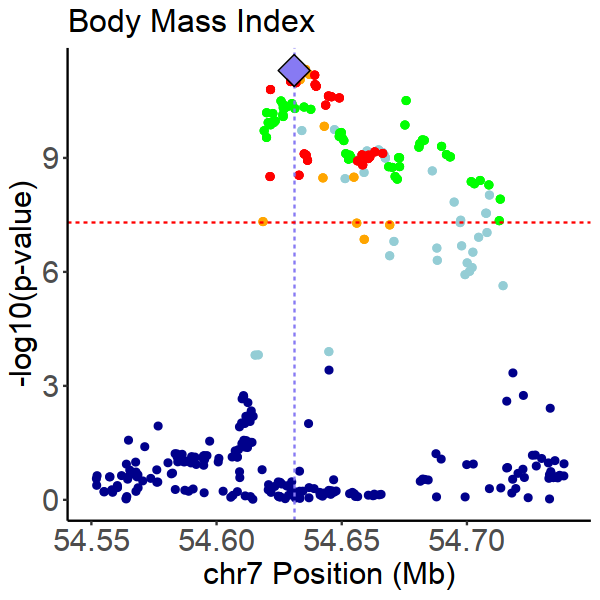

In [26]:
psize(w = 5, h = 5)
tmp = qtldata3 %>% filter(element_id == "Body Mass Index")

p1 = ggplot(tmp, aes(x = pos/1e6, y = -log10(pval), color = color)) + geom_point() + jn_classic + 
#     facet_wrap(.~element_id, ncol = 1) +
    theme(strip.text = element_text(size= 18), plot.title = element_text(hjust = 0)) + xlab("chr7 Position (Mb)") + ylab("-log10(p-value)") + 
    geom_point(data = tmp %>% filter(LD >= 0.2)) + 
    geom_point(data = tmp %>% filter(LD >= 0.4)) + 
    geom_point(data = tmp %>% filter(LD >= 0.8)) +
    scale_color_identity()  +
    geom_vline(xintercept = topsnp_pos/1e6, linetype = "dashed", color = "#877af3")  + 
    geom_hline(data = tmp, aes(yintercept = -log10(thresh)), linetype = "dashed", color = "red") + 
    geom_point(data = tmp %>% filter(pos == topsnp_pos), color = "#877af3", size = 8, shape = 18) + 
    geom_point(data = tmp %>% filter(pos == topsnp_pos), color = "black", size = 6, shape = 5) + 
    xlim(54.55, 54.74) + 
    ggtitle("Body Mass Index")

p1

In [27]:
unique(qtldata3$element_id)

[1] Body Mass Index      ppc_atac_peak_197599
Levels: Body Mass Index ppc_atac_peak_197599

Warning message:
“Removed 20 rows containing missing values (`geom_point()`).”


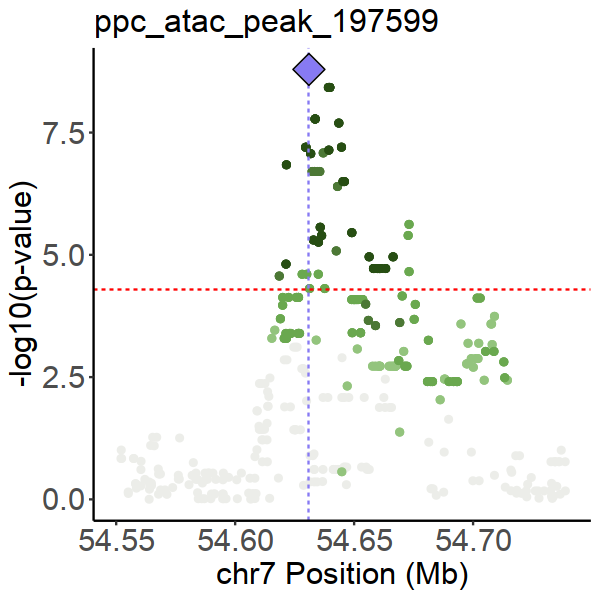

In [28]:
tmp = qtldata3 %>% filter(element_id == "ppc_atac_peak_197599")

p2 = ggplot(tmp, aes(x = pos/1e6, y = -log10(pval), color = color)) + geom_point() + jn_classic + 
#     facet_wrap(.~element_id, ncol = 1) +
    theme(strip.text = element_text(size= 18), plot.title = element_text(hjust = 0)) + xlab("chr7 Position (Mb)") + ylab("-log10(p-value)") + 
    geom_point(data = tmp %>% filter(LD >= 0.2)) + 
    geom_point(data = tmp %>% filter(LD >= 0.4)) + 
    geom_point(data = tmp %>% filter(LD >= 0.8)) +
    scale_color_identity()  +
    geom_vline(xintercept = topsnp_pos/1e6, linetype = "dashed", color = "#877af3")  + 
    geom_hline(data = tmp, aes(yintercept = -log10(thresh)), linetype = "dashed", color = "red") + 
    geom_point(data = tmp %>% filter(pos == topsnp_pos), color = "#877af3", size = 8, shape = 18) + 
    geom_point(data = tmp %>% filter(pos == topsnp_pos), color = "black", size = 6, shape = 5) + 
    xlim(54.55, 54.74) + 
    ggtitle("ppc_atac_peak_197599")

p2

In [29]:
fwrite(qtldata3, "manuscript/figures/SourceData.Figure7.FetalUnique_BMI_Manhattan.txt", row.names = F, sep = "\t")

## read table containing adult QTL associations

In [31]:
ref_qtls = fread("analyses/jennifer/summary_files/reference_qtls.txt", data.table = F) %>%
    mutate(SNP_chr = as.numeric(gsub("chr", "", SNP_chr))) %>%
    filter(SNP_chr == 4)

head(ref_qtls,3)

nrow(ref_qtls)

Warning message in eval(cols[[col]], .data, parent.frame()):
“NAs introduced by coercion”


,id,SNP_chr,SNP_pos_hg38,Pvalue,tissue,analysis,chr
,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>
1,4_126106,4,126106,7.99215e-120,Adipose_Subcutaneous,eqtl_cond,4
2,4_148766,4,148766,3.93565e-44,Adipose_Subcutaneous,eqtl_cond,4
3,4_134876,4,134876,9.28785e-43,Adipose_Subcutaneous,eqtl_cond,4


[1] 201619

## run plink to calculate LD with lead SNP, annotate variants with LD and assign colors

In [32]:
writeLines(c(paste(unlist(strsplit(topsnp, "_"))[2:3], collapse = "_"), 
             unique(ref_qtls[ref_qtls$SNP_pos_hg38 >= 54.55*1e6 & ref_qtls$SNP_pos_hg38 <= 54.74*1e6,]$id)), 
           "analyses/jennifer/scratch/snps.txt", sep = "\n")

reference = paste("analyses/jennifer/gwas_independent/reference", paste0("chr", chr), sep = "/")
out = "analyses/jennifer/scratch/plink"
cmd = paste("plink --extract", "analyses/jennifer/scratch/snps.txt", "--bfile", reference, "--r2", "square", "--out", out, "--make-bed")

message(cmd)
system(cmd)

bim = fread("analyses/jennifer/scratch/plink.bim", data.table = F, header = F) %>% mutate(id = paste(V2, V5, V6, sep = "_")) 

ld = fread("analyses/jennifer/scratch/plink.ld", data.table = F)
rownames(ld) = bim$id
colnames(ld) = bim$id

bim = bim %>% filter(duplicated(V2) == F)

ld = ld[bim$id, bim$id]
colnames(ld) = bim$V2
rownames(ld) = bim$V2

ld = melt(as.matrix(ld)) %>% dplyr::rename(LD = value) %>% filter(Var1 == paste(unlist(strsplit(topsnp, "_"))[2:3], collapse = "_"))

# annotate variants with LD and colors
ref_qtls2 = merge(ref_qtls, ld[,c("Var2", "LD")] %>% dplyr::rename(id = Var2)) %>% filter(!is.na(LD))
ref_qtls2$LD_group = ifelse(ref_qtls2$LD <= 0.2, "<0.2", NA)
ref_qtls2$LD_group = ifelse(ref_qtls2$LD > 0.2 & ref_qtls2$LD <= 0.4, "0.2-0.4", ref_qtls2$LD_group)
ref_qtls2$LD_group = ifelse(ref_qtls2$LD > 0.4 & ref_qtls2$LD <= 0.6, "0.4-0.6", ref_qtls2$LD_group)
ref_qtls2$LD_group = ifelse(ref_qtls2$LD > 0.6 & ref_qtls2$LD <= 0.8, "0.6-0.8", ref_qtls2$LD_group)
ref_qtls2$LD_group = ifelse(ref_qtls2$LD > 0.8, ">0.8", ref_qtls2$LD_group)

ref_qtls2$type = "gwas"

groups = c("<0.2", "0.2-0.4", "0.4-0.6", "0.6-0.8", ">0.8")

color_gradients = list("eqtl" = c("#ecede9", "#ffb344", "#e18c5a", "#8f5137", "#5c4033"), # orange-brown
                       "haqtl" = c("#ecede9", "#9689b9", "#61679a", "#534876", "#2d2c4e"), # purple
                       "caqtl" = c("#ecede9", "#93c47d", "#6aa84f", "#4c7835", "#274e13"), # green
                       "gwas" = c("darkblue", "#94cdd5", "green", "orange", "red"))


ref_qtls3 = as.data.frame(rbindlist(lapply(unique(ref_qtls2$type), function(t)
{
    this = ref_qtls2 %>% filter(type == t)
    this$color = suppressWarnings(mapvalues(this$LD_group, from = groups, to = color_gradients[[t]]))
    return(this)
})))

head(ref_qtls3,2)

plink --extract analyses/jennifer/scratch/snps.txt --bfile analyses/jennifer/gwas_independent/reference/chr4 --r2 square --out analyses/jennifer/scratch/plink --make-bed

Warning message in melt(as.matrix(ld)):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(as.matrix(ld)). In the next version, this warning will become an error.”


,id,SNP_chr,SNP_pos_hg38,Pvalue,tissue,analysis,chr,LD,LD_group,type,color
,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,4_54552279,4,54552279,0.000797634,Kidney_Cortex,eqtl,4,5.98155e-05,<0.2,gwas,darkblue
2,4_54559951,4,54559951,0.000225477,Pituitary,eqtl,4,8.09260e-03,<0.2,gwas,darkblue


## plot

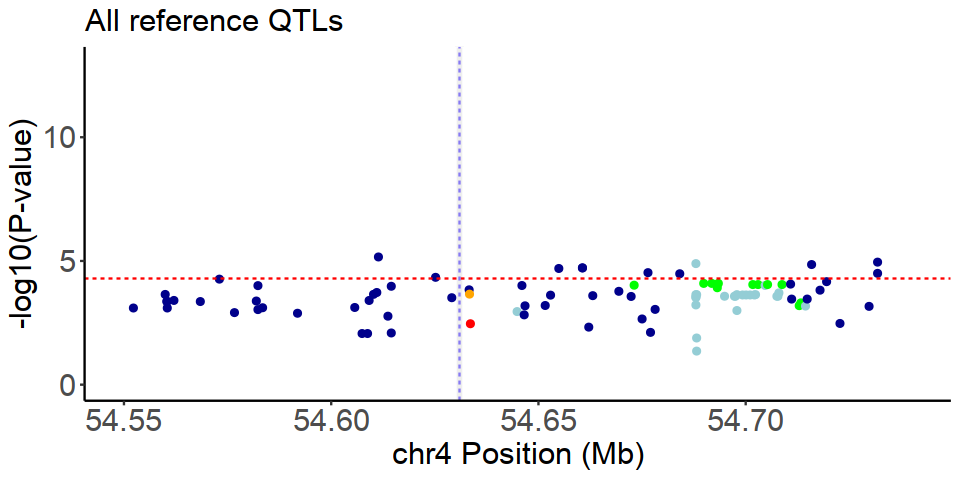

In [34]:
psize(w = 8, h = 4)
p3 = ggplot(ref_qtls3, aes(x = SNP_pos_hg38 / 1e6, y = -log10(Pvalue), color = color)) + 
    geom_rect(xmin = (54631000-1000)/1e6, xmax = (54631000+1000)/1e6, ymin = -Inf, ymax = Inf, fill = "#eeeeee", color = "white") + 
    jn_classic + 
    geom_point() + 
    ggtitle("All reference QTLs") + 
    theme(
        plot.title = element_text(hjust = 0, size = 18)
    ) + 
    scale_color_identity() + 
    geom_hline(yintercept = -log10(5e-5), linetype = "dashed", color = "red") + 
    ylab("-log10(P-value)") + xlab("chr4 Position (Mb)") +
    geom_point(data = ref_qtls3 %>% filter(SNP_pos_hg38 == topsnp_pos), color = "#877af3", size = 8, shape = 18) + 
    geom_point(data = ref_qtls3 %>% filter(SNP_pos_hg38 == topsnp_pos), color = "black", size = 6, shape = 5) + 
    geom_vline(xintercept = topsnp_pos/1e6, linetype = "dashed", color = "#877af3") + 
    xlim(54.55, 54.74) +
    ylim(0, 13)
p3

## plot gene coordinates

Loading objects:
  expdata


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


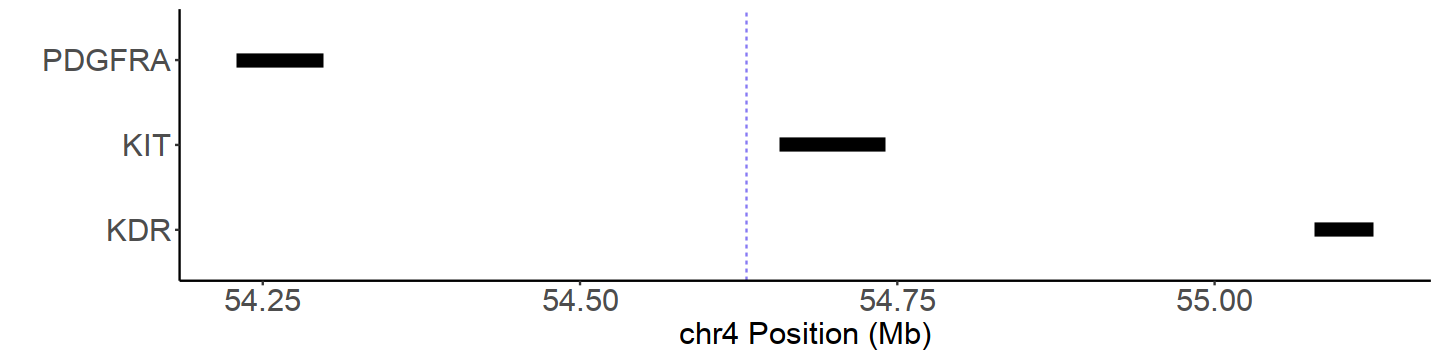

In [35]:
load("eqtls/PPC/step_1/expdata.robj", verbose = T)
geneinfo = fread("/reference/private/Gencode.v44lift38/gene_info.txt", data.table = F) %>% filter(gene_id %in% expdata$element_ids) %>% filter(chrom == "chr4")

psize(w = 12, h = 3)
p4 = ggplot(geneinfo %>% filter(gene_id %in% expdata$element_ids & start >= topsnp_pos-0.5e6 & end <= topsnp_pos+0.5e6)) + 
#     geom_rect(xmin = (topsnp_pos - 1e6) / 1e6, xmax = (topsnp_pos + 1e6) / 1e6, ymin = -Inf, ymax = Inf, fill = "#eeeeee") + 
    geom_segment(aes(x = start/1e6, xend = end/1e6, y = gene_name, yend = gene_name), size = 3) + 
    jn_classic + xlab("chr4 Position (Mb)") + ylab("") +
    geom_vline(xintercept = topsnp_pos/1e6, color = "#877af3", linetype = "dashed") + 
    xlim(54.2, 55.21)  + 
    scale_x_continuous(breaks = c(54.25, 54.5, 54.75, 55))
p4

Warning message:
“Removed 20 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 20 rows containing missing values (`geom_point()`).”


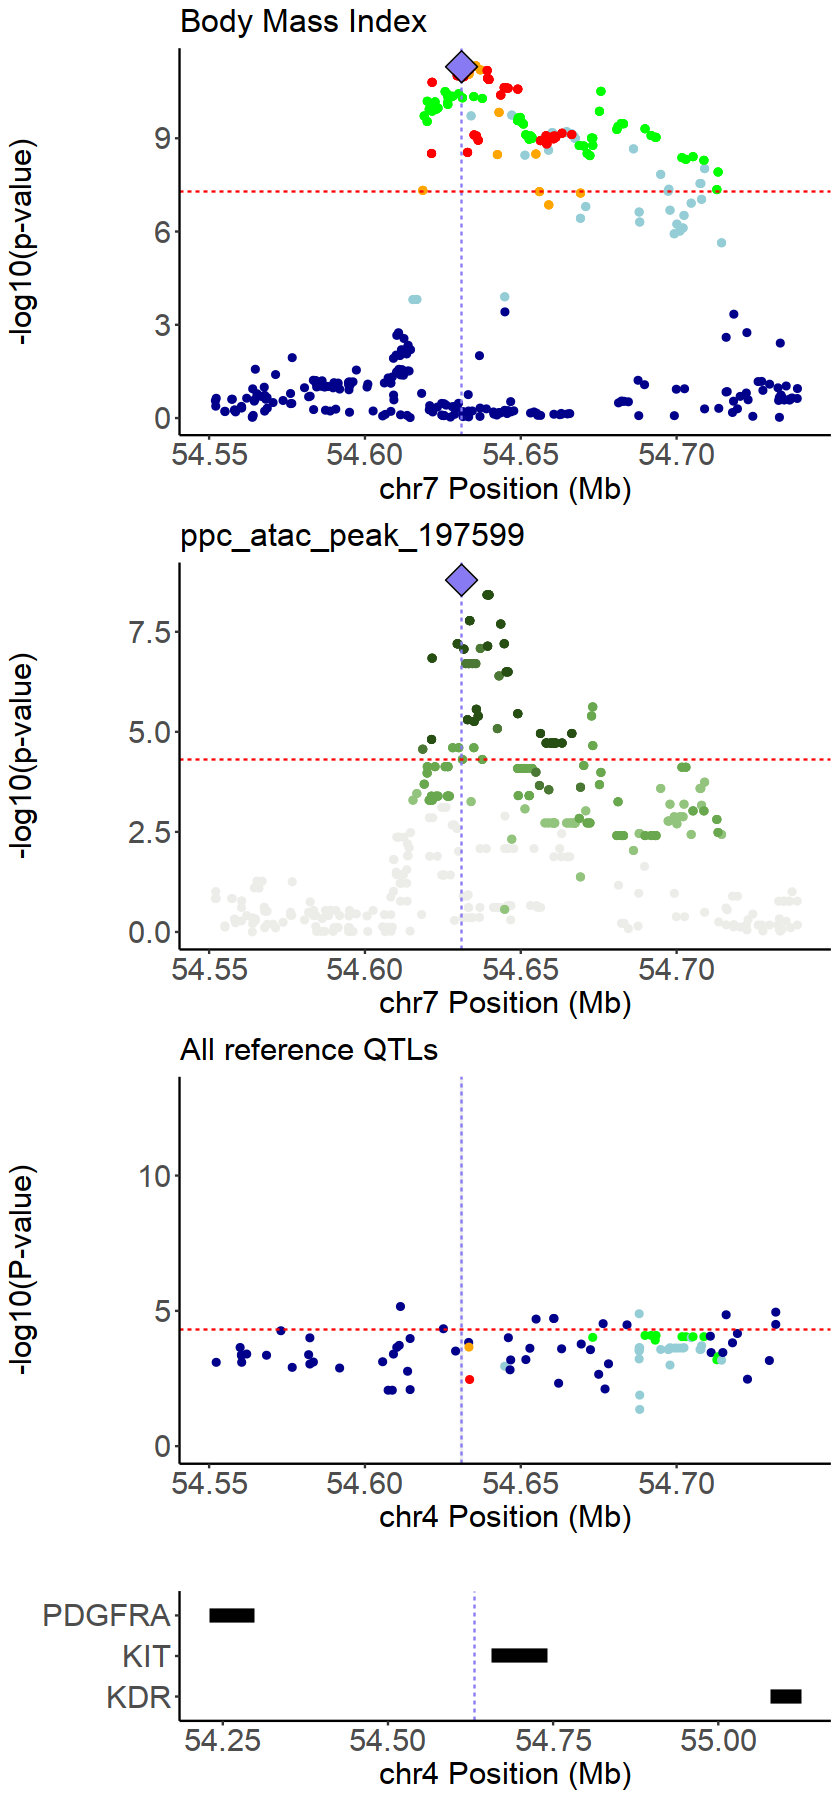

In [36]:
psize(w = 7, h = 15)
plot_grid(p1, p2, p3, p4, ncol = 1, rel_heights = c(0.6, 0.6, 0.6, 0.3), align = "hv")

# Plot boxplot

In [38]:
plot_boxqtl

function (id_cond, id, analysis, tissue, snp) 
{
    metadata = fread(paste(analysis, tissue, "input/metadata_sample.txt", 
        sep = "/"), data.table = F)
    exp = fread(paste(analysis, tissue, "step_1/phenotype/by_element", 
        paste(id, "txt", sep = "."), sep = "/"), data.table = F)
    gt = add_rownames(fread(paste(analysis, tissue, "step_1/genotype/by_element", 
        paste("gt_data", id, "txt", sep = "."), sep = "/"), data.table = F))
    gt = data.frame(t(gt[snp, ]))
    colnames(gt) = "genotype"
    gt$genotype_id = rownames(gt)
    gt = merge(merge(gt, metadata[, c("phenotype_id", "genotype_id")], 
        by = "genotype_id"), exp %>% dplyr::rename(phenotype_id = sample_id), 
        by = "phenotype_id")
    ref = unlist(strsplit(snp, "_"))[4]
    alt = unlist(strsplit(snp, "_"))[5]
    print(table(gt$genotype))
    psize(w = 5, h = 5.5)
    p = ggplot(gt, aes(x = factor(genotype), y = norm)) + geom_boxplot() + 
        geom_jitter(width = 0.2) + geom_smooth(method = "lm", 
        aes(group = 1)) + jn_classic + xlab("") + ylab("Normalized TMM") + 
        scale_x_discrete(labels = c(paste0(ref, ref), paste0(ref, 
            alt), paste0(alt, alt))) + ggtitle(paste(id, snp, 
        sep = "\n"))
    return(p)
}
<bytecode: 0x151af6b8>


  0 0.5   1 
 41  45  23 


`geom_smooth()` using formula = 'y ~ x'


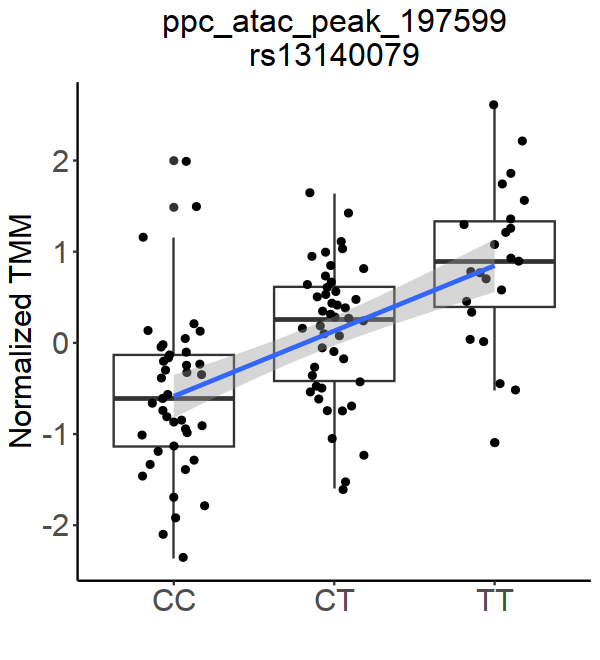

In [37]:
psize(w = 7, h = 7)
plot_boxqtl("ppc_atac_peak_197599_0", "ppc_atac_peak_197599", "caqtls", "PPC", topsnp) + ggtitle("ppc_atac_peak_197599\nrs13140079")

# write source data for boxplot 

In [39]:
id_cond = "ppc_atac_peak_197599_0"
id = "ppc_atac_peak_197599"
analysis = "caqtls"
tissue = "PPC"
snp = topsnp

metadata = fread(paste(analysis, tissue, "input/metadata_sample.txt", sep = "/"), data.table = F)
exp = fread(paste(analysis, tissue, "step_1/phenotype/by_element", paste(id, "txt", sep = "."), sep = "/"), data.table = F)
gt = add_rownames(fread(paste(analysis, tissue, "step_1/genotype/by_element", paste("gt_data", id, "txt", sep = "."), sep = "/"), data.table = F))
gt = data.frame(t(gt[snp, ]))
colnames(gt) = "genotype"
gt$genotype_id = rownames(gt)
gt = merge(merge(gt, metadata[, c("phenotype_id", "genotype_id")], 
    by = "genotype_id"), exp %>% dplyr::rename(phenotype_id = sample_id), 
    by = "phenotype_id")
ref = unlist(strsplit(snp, "_"))[4]
alt = unlist(strsplit(snp, "_"))[5]
print(table(gt$genotype))

gt$genotype = mapvalues(gt$genotype, from = c(0, 0.5, 1), to = c(paste0(ref, ref), paste0(ref, alt), paste0(alt, alt)))


  0 0.5   1 
 41  45  23 


In [40]:
fwrite(gt %>% select(genotype, raw, norm) %>% dplyr::rename(Genotype = genotype, TMM = raw, Normalized_TMM = norm), 
       "manuscript/figures/SourceData.Figure7.Boxplot.txt", row.names = F, sep = "\t")